In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [45]:
# Define data path
DATA_PATH = Path('../Data')

# Load necessary data files
def load_data():
    """
    Load all necessary data files for feature engineering.
    Returns a dictionary of DataFrames.
    """
    data = {}
    
    # Team information
    data['teams'] = pd.read_csv(DATA_PATH / 'MTeams.csv')
    
    # Tournament structure
    data['tourney_seeds'] = pd.read_csv(DATA_PATH / 'MNCAATourneySeeds.csv')
    data['tourney_slots'] = pd.read_csv(DATA_PATH / 'MNCAATourneySlots.csv')
    data['seeds_2024'] = pd.read_csv(DATA_PATH / '2024_tourney_seeds.csv')
    
    # Game results
    data['regular_season_results'] = pd.read_csv(DATA_PATH / 'MRegularSeasonCompactResults.csv')
    data['tourney_results'] = pd.read_csv(DATA_PATH / 'MNCAATourneyCompactResults.csv')
    
    # Detailed stats
    data['regular_season_detailed'] = pd.read_csv(DATA_PATH / 'MRegularSeasonDetailedResults.csv')
    data['tourney_detailed'] = pd.read_csv(DATA_PATH / 'MNCAATourneyDetailedResults.csv')
    
    # Rankings
    data['massey_ordinals'] = pd.read_csv(DATA_PATH / 'MMasseyOrdinals_thruSeason2024_day128.csv')
    
    # Season information
    data['seasons'] = pd.read_csv(DATA_PATH / 'MSeasons.csv')
    
    # Conference information
    data['team_conferences'] = pd.read_csv(DATA_PATH / 'MTeamConferences.csv')
    data['conferences'] = pd.read_csv(DATA_PATH / 'Conferences.csv')
    
    return data

# Load all data
data = load_data()

# Display basic information about the loaded data
for name, df in data.items():
    print(f"{name}: {df.shape[0]} rows, {df.shape[1]} columns")

teams: 378 rows, 4 columns
tourney_seeds: 2558 rows, 3 columns
tourney_slots: 2519 rows, 4 columns
seeds_2024: 128 rows, 3 columns
regular_season_results: 187289 rows, 8 columns
tourney_results: 2451 rows, 8 columns
regular_season_detailed: 113241 rows, 34 columns
tourney_detailed: 1315 rows, 34 columns
massey_ordinals: 5243873 rows, 5 columns
seasons: 40 rows, 6 columns
team_conferences: 13024 rows, 3 columns
conferences: 51 rows, 2 columns


Seasons available: [np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Tournament regions in 2024:
['East' 'West' 'Midwest' 'South']


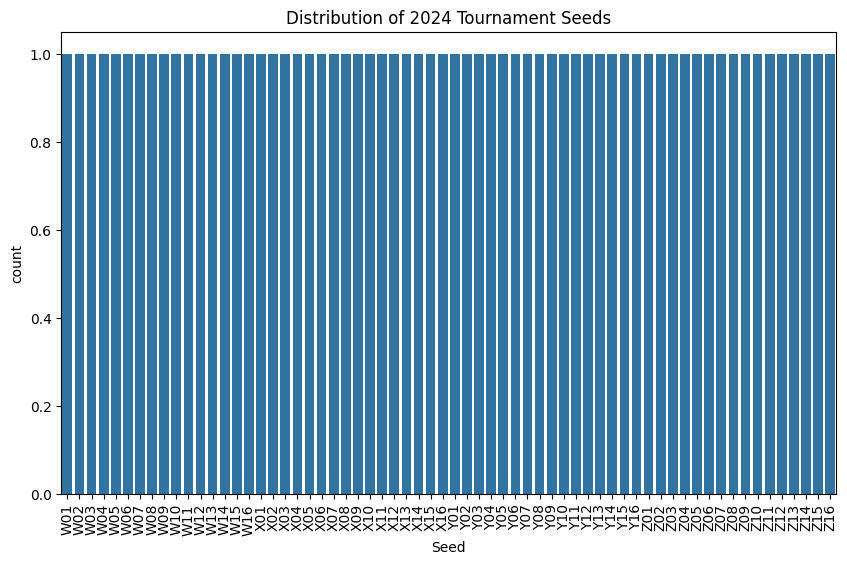


Missing values in tournament seeds:
Season    0
Seed      0
TeamID    0
dtype: int64


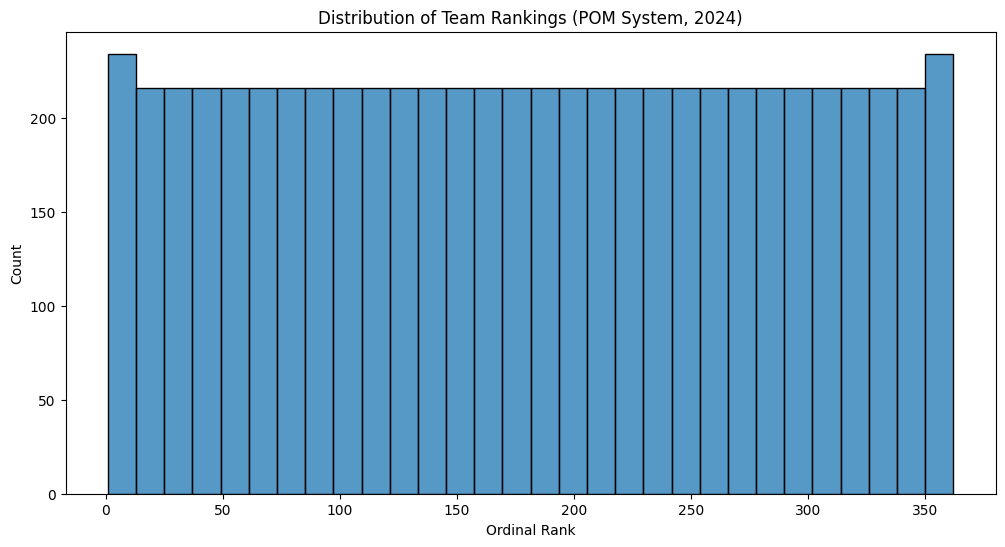

In [46]:
# Exploratory Data Analysis
def explore_data(data):
    """
    Perform basic exploratory analysis on the loaded data.
    """
    # Check years available in the dataset
    print("Seasons available:", sorted(data['seasons']['Season'].unique()))
    
    # Check tournament structure
    print("\nTournament regions in 2024:")
    print(data['seasons'][data['seasons']['Season'] == 2024][['RegionW', 'RegionX', 'RegionY', 'RegionZ']].values[0])
    
    # Sample tournament seeds distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Seed', data=data['seeds_2024'][data['seeds_2024']['Tournament'] == 'M'])
    plt.title('Distribution of 2024 Tournament Seeds')
    plt.xticks(rotation=90)
    plt.show()
    
    # Check for missing values in key datasets
    print("\nMissing values in tournament seeds:")
    print(data['tourney_seeds'].isnull().sum())
    
    # Look at the distribution of team rankings
    if 'massey_ordinals' in data:
        recent_rankings = data['massey_ordinals'][
            (data['massey_ordinals']['Season'] == 2024) & 
            (data['massey_ordinals']['SystemName'] == 'POM')
        ]
        if not recent_rankings.empty:
            plt.figure(figsize=(12, 6))
            sns.histplot(recent_rankings['OrdinalRank'], bins=30)
            plt.title('Distribution of Team Rankings (POM System, 2024)')
            plt.xlabel('Ordinal Rank')
            plt.show()

explore_data(data)

In [47]:
# Data preprocessing functions
def preprocess_tourney_seeds(df):
    """
    Preprocess tournament seeds data to extract numeric seed value.
    """
    # Extract region and seed number
    df = df.copy()
    df['Region'] = df['Seed'].str[0]
    df['SeedNumber'] = df['Seed'].str[1:3].astype(int)
    return df

def preprocess_regular_season_results(regular_season):
    """
    Preprocess regular season results and add a column to indicate 
    they are not tournament games.
    """
    regular_season = regular_season.copy()
    regular_season['IsTournament'] = 0
    
    # Sort by season and day number
    regular_season = regular_season.sort_values(['Season', 'DayNum'])
    
    return regular_season

# Preprocess the data
processed_tourney_seeds = preprocess_tourney_seeds(data['tourney_seeds'])
processed_regular_season = preprocess_regular_season_results(data['regular_season_results'])

# Display sample of processed data
print("Processed Tournament Seeds Sample:")
print(processed_tourney_seeds.head())
print("\nProcessed Regular Season Results Sample:")
print(processed_regular_season.head())


Processed Tournament Seeds Sample:
   Season Seed  TeamID Region  SeedNumber
0    1985  W01    1207      W           1
1    1985  W02    1210      W           2
2    1985  W03    1228      W           3
3    1985  W04    1260      W           4
4    1985  W05    1374      W           5

Processed Regular Season Results Sample:
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  IsTournament
0    1985      20     1228      81     1328      64    N      0             0
1    1985      25     1106      77     1354      70    H      0             0
2    1985      25     1112      63     1223      56    H      0             0
3    1985      25     1165      70     1432      54    H      0             0
4    1985      25     1192      86     1447      74    H      0             0


In [48]:
# Feature Engineering: Seed-based Features
def create_seed_features(tourney_results, tourney_seeds):
    """
    Create features based on tournament seeds.
    """
    # Create a temporary DataFrame with team IDs and seeds
    team_seeds = tourney_seeds.copy()
    
    # Prepare dataset for tournament games with seed information
    tourney_games = tourney_results.copy()
    
    # Merge seeds for winning and losing teams
    tourney_games = tourney_games.merge(
        team_seeds[['Season', 'TeamID', 'SeedNumber']],
        left_on=['Season', 'WTeamID'],
        right_on=['Season', 'TeamID'],
        how='left'
    ).rename(columns={'SeedNumber': 'WSeedNumber'})
    
    tourney_games = tourney_games.merge(
        team_seeds[['Season', 'TeamID', 'SeedNumber']],
        left_on=['Season', 'LTeamID'],
        right_on=['Season', 'TeamID'],
        how='left'
    ).rename(columns={'SeedNumber': 'LSeedNumber'})
    
    # Drop the redundant TeamID columns
    tourney_games = tourney_games.drop(['TeamID_x', 'TeamID_y'], axis=1)
    
    # Create seed-based features
    tourney_games['SeedDiff'] = tourney_games['WSeedNumber'] - tourney_games['LSeedNumber']
    tourney_games['SeedProduct'] = tourney_games['WSeedNumber'] * tourney_games['LSeedNumber']
    tourney_games['SeedSum'] = tourney_games['WSeedNumber'] + tourney_games['LSeedNumber']
    tourney_games['SeedRatio'] = tourney_games['WSeedNumber'] / tourney_games['LSeedNumber']
    
    return tourney_games

# Create seed-based features for tournament games
tourney_games_with_seeds = create_seed_features(
    data['tourney_results'], 
    processed_tourney_seeds
)

print("Tournament Games with Seed Features:")
print(tourney_games_with_seeds.head())

Tournament Games with Seed Features:
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WSeedNumber  LSeedNumber  SeedDiff  SeedProduct  SeedSum  SeedRatio
0    1985     136     1116      63     1234      54    N      0            9            8         1           72       17   1.125000
1    1985     136     1120      59     1345      58    N      0           11            6         5           66       17   1.833333
2    1985     136     1207      68     1250      43    N      0            1           16       -15           16       17   0.062500
3    1985     136     1229      58     1425      55    N      0            9            8         1           72       17   1.125000
4    1985     136     1242      49     1325      38    N      0            3           14       -11           42       17   0.214286


In [49]:
# Feature Engineering: Team Performance Metrics
def create_team_performance_features(regular_season, seasons):
    """
    Create team performance metrics based on regular season results.
    """
    # List to store results for each season
    team_stats_by_season = []
    
    # Process each season separately
    for season in sorted(seasons['Season'].unique()):
        season_games = regular_season[regular_season['Season'] == season]
        
        # Winning team stats
        w_stats = season_games.groupby('WTeamID').agg(
            Games_Won=('WScore', 'count'),
            Points_Scored_Win=('WScore', 'sum'),
            Points_Allowed_Win=('LScore', 'sum')
        ).reset_index()
        
        # Losing team stats
        l_stats = season_games.groupby('LTeamID').agg(
            Games_Lost=('LScore', 'count'),
            Points_Scored_Loss=('LScore', 'sum'),
            Points_Allowed_Loss=('WScore', 'sum')
        ).reset_index()
        
        # Merge winning and losing stats
        w_stats = w_stats.rename(columns={'WTeamID': 'TeamID'})
        l_stats = l_stats.rename(columns={'LTeamID': 'TeamID'})
        
        team_stats = pd.merge(w_stats, l_stats, on='TeamID', how='outer').fillna(0)
        
        # Calculate additional metrics
        team_stats['Season'] = season
        team_stats['Games_Played'] = team_stats['Games_Won'] + team_stats['Games_Lost']
        team_stats['Win_Rate'] = team_stats['Games_Won'] / team_stats['Games_Played']
        
        team_stats['Total_Points_Scored'] = team_stats['Points_Scored_Win'] + team_stats['Points_Scored_Loss']
        team_stats['Total_Points_Allowed'] = team_stats['Points_Allowed_Win'] + team_stats['Points_Allowed_Loss']
        
        team_stats['Avg_Points_Scored'] = team_stats['Total_Points_Scored'] / team_stats['Games_Played']
        team_stats['Avg_Points_Allowed'] = team_stats['Total_Points_Allowed'] / team_stats['Games_Played']
        team_stats['Point_Differential'] = team_stats['Avg_Points_Scored'] - team_stats['Avg_Points_Allowed']
        
        # Append to the list
        team_stats_by_season.append(team_stats)
    
    # Combine all seasons
    all_team_stats = pd.concat(team_stats_by_season)
    
    return all_team_stats

# Create team performance metrics
team_performance = create_team_performance_features(
    data['regular_season_results'], 
    data['seasons']
)

print("Team Performance Metrics:")
print(team_performance.head())

Team Performance Metrics:
   TeamID  Games_Won  Points_Scored_Win  Points_Allowed_Win  Games_Lost  Points_Scored_Loss  Points_Allowed_Loss  Season  Games_Played  Win_Rate  Total_Points_Scored  Total_Points_Allowed  Avg_Points_Scored  Avg_Points_Allowed  Point_Differential
0    1102        5.0              355.0               305.0        19.0              1159.0               1348.0    1985          24.0  0.208333               1514.0                1653.0          63.083333           68.875000           -5.791667
1    1103        9.0              632.0               564.0        14.0               772.0                910.0    1985          23.0  0.391304               1404.0                1474.0          61.043478           64.086957           -3.043478
2    1104       21.0             1514.0              1237.0         9.0               541.0                584.0    1985          30.0  0.700000               2055.0                1821.0          68.500000           60.700000       

In [50]:
# Feature Engineering: Detailed Statistics Features
def create_detailed_stat_features(detailed_results):
    """
    Create features based on detailed box score statistics.
    """
    # List to store results for each season
    team_detailed_stats = []
    
    # Get unique seasons
    seasons = detailed_results['Season'].unique()
    
    for season in seasons:
        season_games = detailed_results[detailed_results['Season'] == season]
        
        # Winning team stats
        w_stats = season_games.groupby('WTeamID').agg({
            'WFGM': 'sum', 'WFGA': 'sum', 
            'WFGM3': 'sum', 'WFGA3': 'sum',
            'WFTM': 'sum', 'WFTA': 'sum',
            'WOR': 'sum', 'WDR': 'sum',
            'WAst': 'sum', 'WTO': 'sum',
            'WStl': 'sum', 'WBlk': 'sum',
            'WPF': 'sum',
            'WScore': 'count'  # Number of games won
        }).reset_index()
        
        w_stats = w_stats.rename(columns={
            'WTeamID': 'TeamID',
            'WFGM': 'FGM_Win', 'WFGA': 'FGA_Win',
            'WFGM3': 'FGM3_Win', 'WFGA3': 'FGA3_Win',
            'WFTM': 'FTM_Win', 'WFTA': 'FTA_Win',
            'WOR': 'OR_Win', 'WDR': 'DR_Win',
            'WAst': 'Ast_Win', 'WTO': 'TO_Win',
            'WStl': 'Stl_Win', 'WBlk': 'Blk_Win',
            'WPF': 'PF_Win',
            'WScore': 'Games_Won'
        })
        
        # Losing team stats
        l_stats = season_games.groupby('LTeamID').agg({
            'LFGM': 'sum', 'LFGA': 'sum', 
            'LFGM3': 'sum', 'LFGA3': 'sum',
            'LFTM': 'sum', 'LFTA': 'sum',
            'LOR': 'sum', 'LDR': 'sum',
            'LAst': 'sum', 'LTO': 'sum',
            'LStl': 'sum', 'LBlk': 'sum',
            'LPF': 'sum',
            'LScore': 'count'  # Number of games lost
        }).reset_index()
        
        l_stats = l_stats.rename(columns={
            'LTeamID': 'TeamID',
            'LFGM': 'FGM_Loss', 'LFGA': 'FGA_Loss',
            'LFGM3': 'FGM3_Loss', 'LFGA3': 'FGA3_Loss',
            'LFTM': 'FTM_Loss', 'LFTA': 'FTA_Loss',
            'LOR': 'OR_Loss', 'LDR': 'DR_Loss',
            'LAst': 'Ast_Loss', 'LTO': 'TO_Loss',
            'LStl': 'Stl_Loss', 'LBlk': 'Blk_Loss',
            'LPF': 'PF_Loss',
            'LScore': 'Games_Lost'
        })
        
        # Merge winning and losing stats
        team_stats = pd.merge(w_stats, l_stats, on='TeamID', how='outer').fillna(0)
        team_stats['Season'] = season
        
        # Calculate combined stats
        team_stats['Games_Played'] = team_stats['Games_Won'] + team_stats['Games_Lost']
        
        # Field goal percentages
        team_stats['FGM'] = team_stats['FGM_Win'] + team_stats['FGM_Loss']
        team_stats['FGA'] = team_stats['FGA_Win'] + team_stats['FGA_Loss']
        team_stats['FG_Pct'] = team_stats['FGM'] / team_stats['FGA']
        
        # Three-point percentages
        team_stats['FGM3'] = team_stats['FGM3_Win'] + team_stats['FGM3_Loss']
        team_stats['FGA3'] = team_stats['FGA3_Win'] + team_stats['FGA3_Loss']
        team_stats['FG3_Pct'] = team_stats['FGM3'] / team_stats['FGA3']
        
        # Free throw percentages
        team_stats['FTM'] = team_stats['FTM_Win'] + team_stats['FTM_Loss']
        team_stats['FTA'] = team_stats['FTA_Win'] + team_stats['FTA_Loss']
        team_stats['FT_Pct'] = team_stats['FTM'] / team_stats['FTA']
        
        # Rebounding
        team_stats['OR'] = team_stats['OR_Win'] + team_stats['OR_Loss']
        team_stats['DR'] = team_stats['DR_Win'] + team_stats['DR_Loss']
        team_stats['Total_Rebounds'] = team_stats['OR'] + team_stats['DR']
        
        # Other stats
        team_stats['Ast'] = team_stats['Ast_Win'] + team_stats['Ast_Loss']
        team_stats['TO'] = team_stats['TO_Win'] + team_stats['TO_Loss']
        team_stats['Stl'] = team_stats['Stl_Win'] + team_stats['Stl_Loss']
        team_stats['Blk'] = team_stats['Blk_Win'] + team_stats['Blk_Loss']
        team_stats['PF'] = team_stats['PF_Win'] + team_stats['PF_Loss']
        
        # Per-game metrics
        team_stats['FG_Pct_PerGame'] = team_stats['FG_Pct']
        team_stats['FG3_Pct_PerGame'] = team_stats['FG3_Pct']
        team_stats['FT_Pct_PerGame'] = team_stats['FT_Pct']
        team_stats['OR_PerGame'] = team_stats['OR'] / team_stats['Games_Played']
        team_stats['DR_PerGame'] = team_stats['DR'] / team_stats['Games_Played']
        team_stats['Ast_PerGame'] = team_stats['Ast'] / team_stats['Games_Played']
        team_stats['TO_PerGame'] = team_stats['TO'] / team_stats['Games_Played']
        team_stats['Stl_PerGame'] = team_stats['Stl'] / team_stats['Games_Played']
        team_stats['Blk_PerGame'] = team_stats['Blk'] / team_stats['Games_Played']
        
        # Advanced metrics
        team_stats['Ast_TO_Ratio'] = team_stats['Ast'] / team_stats['TO']
        team_stats['Stl_TO_Ratio'] = team_stats['Stl'] / team_stats['TO']
        
        team_detailed_stats.append(team_stats)
    
    # Combine all seasons
    all_detailed_stats = pd.concat(team_detailed_stats)
    
    return all_detailed_stats

# Create detailed statistics features if detailed data is available
# Note: Detailed results are only available from 2003 onwards
if 'regular_season_detailed' in data:
    team_detailed_stats = create_detailed_stat_features(data['regular_season_detailed'])
    print("Team Detailed Statistics:")
    print(team_detailed_stats.head())
else:
    print("Detailed statistics not available")

Team Detailed Statistics:
   TeamID  FGM_Win  FGA_Win  FGM3_Win  FGA3_Win  FTM_Win  FTA_Win  OR_Win  DR_Win  Ast_Win  TO_Win  Stl_Win  Blk_Win  PF_Win  Games_Won  FGM_Loss  FGA_Loss  FGM3_Loss  FGA3_Loss  FTM_Loss  FTA_Loss  OR_Loss  DR_Loss  Ast_Loss  TO_Loss  Stl_Loss  Blk_Loss  PF_Loss  Games_Lost  Season  Games_Played    FGM     FGA    FG_Pct   FGM3   FGA3   FG3_Pct    FTM    FTA    FT_Pct     OR     DR  Total_Rebounds    Ast     TO    Stl    Blk     PF  FG_Pct_PerGame  FG3_Pct_PerGame  FT_Pct_PerGame  OR_PerGame  DR_PerGame  Ast_PerGame  TO_PerGame  Stl_PerGame  Blk_PerGame  Ast_TO_Ratio  Stl_TO_Ratio
0    1102    271.0    480.0     120.0     259.0    163.0    249.0    46.0   232.0    203.0   133.0     88.0     34.0   193.0       12.0     265.0     634.0       99.0      324.0     149.0     230.0     71.0    239.0     161.0    187.0      79.0      16.0    332.0        16.0    2003          28.0  536.0  1114.0  0.481149  219.0  583.0  0.375643  312.0  479.0  0.651357  117.0  471.0  

In [51]:
# Feature Engineering: Ranking System Features
def create_ranking_features(massey_ordinals, final_day=128):
    """
    Create features based on various ranking systems.
    Focus on the final rankings before the tournament.
    """
    # Filter for the final rankings before tournament (day 128 or 133)
    final_rankings = massey_ordinals[massey_ordinals['RankingDayNum'] == final_day]
    
    # Get the most common ranking systems
    ranking_systems = final_rankings['SystemName'].value_counts().nlargest(10).index.tolist()
    
    # Filter for the most common systems
    common_rankings = final_rankings[final_rankings['SystemName'].isin(ranking_systems)]
    
    # Pivot to get rankings by system for each team and season
    team_rankings = common_rankings.pivot_table(
        index=['Season', 'TeamID'],
        columns='SystemName',
        values='OrdinalRank'
    ).reset_index()
    
    # Calculate aggregate ranking metrics
    ranking_cols = [col for col in team_rankings.columns if col not in ['Season', 'TeamID']]
    
    team_rankings['Mean_Rank'] = team_rankings[ranking_cols].mean(axis=1)
    team_rankings['Median_Rank'] = team_rankings[ranking_cols].median(axis=1)
    team_rankings['Std_Rank'] = team_rankings[ranking_cols].std(axis=1)
    team_rankings['Min_Rank'] = team_rankings[ranking_cols].min(axis=1)
    team_rankings['Max_Rank'] = team_rankings[ranking_cols].max(axis=1)
    
    return team_rankings

# Create ranking features
team_rankings = create_ranking_features(data['massey_ordinals'])
print("Team Ranking Features:")
print(team_rankings.head())

Team Ranking Features:
SystemName  Season  TeamID  7OT    COL  DOK    DOL    MOR  PGH    POM    SAG    WLK    WOB   Mean_Rank  Median_Rank   Std_Rank  Min_Rank  Max_Rank
0             2005    1102  NaN  110.0  NaN   80.0   52.0  NaN   54.0   73.0   83.0   97.0   78.428571         80.0  21.172759      52.0     110.0
1             2005    1103  NaN   68.0  NaN   72.0   95.0  NaN   75.0   74.0   66.0   74.0   74.857143         74.0   9.494359      66.0      95.0
2             2005    1104  NaN   17.0  NaN   16.0   13.0  NaN   18.0   14.0   17.0   19.0   16.285714         17.0   2.138090      13.0      19.0
3             2005    1105  NaN  267.0  NaN  290.0  304.0  NaN  291.0  292.0  271.0  257.0  281.714286        290.0  16.829679     257.0     304.0
4             2005    1106  NaN  257.0  NaN  296.0  308.0  NaN  300.0  302.0  287.0  263.0  287.571429        296.0  19.957097     257.0     308.0


In [52]:
# Feature Engineering: Conference Strength Features
def create_conference_features(team_conferences, tourney_results, regular_season):
    """
    Create features based on conference performance.
    """
    # List to store results
    conf_strength_by_season = []
    
    # Process each season
    for season in sorted(team_conferences['Season'].unique()):
        # Get conference mapping for the season
        season_confs = team_conferences[team_conferences['Season'] == season]
        team_to_conf = dict(zip(season_confs['TeamID'], season_confs['ConfAbbrev']))
        
        # Get tournament results for the season
        season_tourney = tourney_results[tourney_results['Season'] == season]
        
        # Get regular season results for the season
        season_regular = regular_season[regular_season['Season'] == season]
        
        # Create empty DataFrames to avoid KeyErrors later
        conf_tourney_perf = pd.DataFrame(columns=['ConfAbbrev', 'Tourney_Wins', 'Tourney_Losses'])
        conf_reg_perf = pd.DataFrame(columns=['ConfAbbrev', 'InterConf_Wins', 'InterConf_Losses'])
        
        # Process tournament data if available
        if not season_tourney.empty:
            season_tourney['WConf'] = season_tourney['WTeamID'].map(team_to_conf)
            season_tourney['LConf'] = season_tourney['LTeamID'].map(team_to_conf)
            
            # Conference performance in tournament
            conf_tourney_wins = season_tourney.groupby('WConf').size().reset_index(name='Tourney_Wins')
            conf_tourney_losses = season_tourney.groupby('LConf').size().reset_index(name='Tourney_Losses')
            
            # Merge wins and losses
            conf_tourney_perf = pd.merge(
                conf_tourney_wins, 
                conf_tourney_losses, 
                left_on='WConf', 
                right_on='LConf', 
                how='outer'
            ).fillna(0)
            
            # Clean up column names
            conf_tourney_perf = conf_tourney_perf.rename(columns={'WConf': 'ConfAbbrev'})
            if 'LConf' in conf_tourney_perf.columns:
                conf_tourney_perf = conf_tourney_perf.drop('LConf', axis=1)
        
        # Process regular season data if available
        if not season_regular.empty:
            season_regular['WConf'] = season_regular['WTeamID'].map(team_to_conf)
            season_regular['LConf'] = season_regular['LTeamID'].map(team_to_conf)
            
            # Count inter-conference games in regular season
            inter_conf_games = season_regular[season_regular['WConf'] != season_regular['LConf']]
            
            if not inter_conf_games.empty:
                # Conference wins in inter-conference games
                conf_reg_wins = inter_conf_games.groupby('WConf').size().reset_index(name='InterConf_Wins')
                conf_reg_losses = inter_conf_games.groupby('LConf').size().reset_index(name='InterConf_Losses')
                
                # Merge inter-conference performance
                conf_reg_perf = pd.merge(
                    conf_reg_wins, 
                    conf_reg_losses, 
                    left_on='WConf', 
                    right_on='LConf', 
                    how='outer'
                ).fillna(0)
                
                # Clean up column names
                conf_reg_perf = conf_reg_perf.rename(columns={'WConf': 'ConfAbbrev'})
                if 'LConf' in conf_reg_perf.columns:
                    conf_reg_perf = conf_reg_perf.drop('LConf', axis=1)
        
        # Merge tournament and regular season performance
        if not conf_tourney_perf.empty and not conf_reg_perf.empty:
            conf_perf = pd.merge(conf_tourney_perf, conf_reg_perf, on='ConfAbbrev', how='outer').fillna(0)
        elif not conf_tourney_perf.empty:
            conf_perf = conf_tourney_perf
            conf_perf['InterConf_Wins'] = 0
            conf_perf['InterConf_Losses'] = 0
        elif not conf_reg_perf.empty:
            conf_perf = conf_reg_perf
            conf_perf['Tourney_Wins'] = 0
            conf_perf['Tourney_Losses'] = 0
        else:
            # Create empty DataFrame with all needed columns
            all_confs = season_confs['ConfAbbrev'].unique()
            conf_perf = pd.DataFrame({'ConfAbbrev': all_confs})
            conf_perf['Tourney_Wins'] = 0
            conf_perf['Tourney_Losses'] = 0
            conf_perf['InterConf_Wins'] = 0
            conf_perf['InterConf_Losses'] = 0
        
        # Calculate additional metrics
        conf_perf['Season'] = season
        conf_perf['Tourney_Games'] = conf_perf['Tourney_Wins'] + conf_perf['Tourney_Losses']
        conf_perf['InterConf_Games'] = conf_perf['InterConf_Wins'] + conf_perf['InterConf_Losses']
        
        # Calculate rates with handling for division by zero
        conf_perf['Tourney_Win_Rate'] = np.where(
            conf_perf['Tourney_Games'] > 0,
            conf_perf['Tourney_Wins'] / conf_perf['Tourney_Games'],
            0
        )
        
        conf_perf['InterConf_Win_Rate'] = np.where(
            conf_perf['InterConf_Games'] > 0,
            conf_perf['InterConf_Wins'] / conf_perf['InterConf_Games'],
            0
        )
        
        # Append to the list
        conf_strength_by_season.append(conf_perf)
    
    # Combine all seasons
    all_conf_strength = pd.concat(conf_strength_by_season)
    
    return all_conf_strength

# Create conference strength features
conf_strength = create_conference_features(
    data['team_conferences'], 
    data['tourney_results'],
    data['regular_season_results']
)

print("Conference Strength Features:")
print(conf_strength.head())

Conference Strength Features:
  ConfAbbrev  Tourney_Wins  Tourney_Losses  InterConf_Wins  InterConf_Losses  Season  Tourney_Games  InterConf_Games  Tourney_Win_Rate  InterConf_Win_Rate
0          0           0.0             1.0             0.0               0.0    1985            1.0              0.0               0.0                 0.0
1          0           0.0             1.0             0.0               0.0    1985            1.0              0.0               0.0                 0.0
2          0           0.0             1.0             0.0               0.0    1985            1.0              0.0               0.0                 0.0
3          0           0.0             1.0             0.0               0.0    1985            1.0              0.0               0.0                 0.0
4          0           0.0             1.0             0.0               0.0    1985            1.0              0.0               0.0                 0.0


In [53]:
# Feature Engineering: Game Location Features
def create_location_features(regular_season_results):
    """
    Create features based on team performance by location (home/away/neutral).
    """
    # List to store results for each season
    location_stats_by_season = []
    
    # Process each season
    for season in sorted(regular_season_results['Season'].unique()):
        season_games = regular_season_results[regular_season_results['Season'] == season]
        
        # Home game stats (when WLoc = 'H')
        home_games = season_games[season_games['WLoc'] == 'H']
        
        # Home wins
        home_wins = home_games.groupby('WTeamID').agg(
            Home_Wins=('WScore', 'count'),
            Home_Points_For=('WScore', 'sum'),
            Home_Points_Against=('LScore', 'sum')
        ).reset_index().rename(columns={'WTeamID': 'TeamID'})
        
        # Home losses
        home_losses = season_games[season_games['WLoc'] == 'A'].groupby('LTeamID').agg(
            Home_Losses=('LScore', 'count'),
            Home_Loss_Points_For=('LScore', 'sum'),
            Home_Loss_Points_Against=('WScore', 'sum')
        ).reset_index().rename(columns={'LTeamID': 'TeamID'})
        
        # Away game stats (when WLoc = 'A')
        away_games = season_games[season_games['WLoc'] == 'A']
        
        # Away wins
        away_wins = away_games.groupby('WTeamID').agg(
            Away_Wins=('WScore', 'count'),
            Away_Points_For=('WScore', 'sum'),
            Away_Points_Against=('LScore', 'sum')
        ).reset_index().rename(columns={'WTeamID': 'TeamID'})
        
        # Away losses
        away_losses = season_games[season_games['WLoc'] == 'H'].groupby('LTeamID').agg(
            Away_Losses=('LScore', 'count'),
            Away_Loss_Points_For=('LScore', 'sum'),
            Away_Loss_Points_Against=('WScore', 'sum')
        ).reset_index().rename(columns={'LTeamID': 'TeamID'})
        
        # Neutral game stats (when WLoc = 'N')
        neutral_games = season_games[season_games['WLoc'] == 'N']
        
        # Neutral wins
        neutral_wins = neutral_games.groupby('WTeamID').agg(
            Neutral_Wins=('WScore', 'count'),
            Neutral_Points_For=('WScore', 'sum'),
            Neutral_Points_Against=('LScore', 'sum')
        ).reset_index().rename(columns={'WTeamID': 'TeamID'})
        
        # Neutral losses
        neutral_losses = neutral_games.groupby('LTeamID').agg(
            Neutral_Losses=('LScore', 'count'),
            Neutral_Loss_Points_For=('LScore', 'sum'),
            Neutral_Loss_Points_Against=('WScore', 'sum')
        ).reset_index().rename(columns={'LTeamID': 'TeamID'})
        
        # Merge all location stats
        dfs = [home_wins, home_losses, away_wins, away_losses, neutral_wins, neutral_losses]
        location_stats = dfs[0]
        
        for df in dfs[1:]:
            location_stats = pd.merge(location_stats, df, on='TeamID', how='outer')
        
        location_stats = location_stats.fillna(0)
        location_stats['Season'] = season
        
        # Calculate derived metrics
        # Home performance
        location_stats['Home_Games'] = location_stats['Home_Wins'] + location_stats['Home_Losses']
        location_stats['Home_Win_Rate'] = location_stats['Home_Wins'] / location_stats['Home_Games'].replace(0, 1)
        
        # Away performance
        location_stats['Away_Games'] = location_stats['Away_Wins'] + location_stats['Away_Losses']
        location_stats['Away_Win_Rate'] = location_stats['Away_Wins'] / location_stats['Away_Games'].replace(0, 1)
        
        # Neutral performance
        location_stats['Neutral_Games'] = location_stats['Neutral_Wins'] + location_stats['Neutral_Losses']
        location_stats['Neutral_Win_Rate'] = location_stats['Neutral_Wins'] / location_stats['Neutral_Games'].replace(0, 1)
        
        # Point differentials by location
        location_stats['Home_Point_Diff'] = (location_stats['Home_Points_For'] - location_stats['Home_Points_Against']) / location_stats['Home_Games'].replace(0, 1)
        location_stats['Away_Point_Diff'] = (location_stats['Away_Points_For'] - location_stats['Away_Points_Against']) / location_stats['Away_Games'].replace(0, 1)
        location_stats['Neutral_Point_Diff'] = (location_stats['Neutral_Points_For'] - location_stats['Neutral_Points_Against']) / location_stats['Neutral_Games'].replace(0, 1)
        
        location_stats_by_season.append(location_stats)
    
    # Combine all seasons
    all_location_stats = pd.concat(location_stats_by_season)
    
    return all_location_stats

# Create location-based features
location_features = create_location_features(data['regular_season_results'])
print("Location Features:")
print(location_features.head())

Location Features:
   TeamID  Home_Wins  Home_Points_For  Home_Points_Against  Home_Losses  Home_Loss_Points_For  Home_Loss_Points_Against  Away_Wins  Away_Points_For  Away_Points_Against  Away_Losses  Away_Loss_Points_For  Away_Loss_Points_Against  Neutral_Wins  Neutral_Points_For  Neutral_Points_Against  Neutral_Losses  Neutral_Loss_Points_For  Neutral_Loss_Points_Against  Season  Home_Games  Home_Win_Rate  Away_Games  Away_Win_Rate  Neutral_Games  Neutral_Win_Rate  Home_Point_Diff  Away_Point_Diff  Neutral_Point_Diff
0    1102        2.0            143.0                110.0          8.0                 506.0                     555.0        3.0            212.0                195.0          9.0                 542.0                     657.0           0.0                 0.0                     0.0             2.0                    111.0                        136.0    1985        10.0       0.200000        12.0       0.250000            2.0          0.000000         3.300000     

In [54]:
# Feature Engineering: Historical Tournament Performance Features
def create_historical_tourney_features(tourney_results, processed_tourney_seeds):
    """
    Create features based on teams' historical tournament performance.
    """
    # Combine seeds and results
    tourney_games_with_seeds = create_seed_features(tourney_results, processed_tourney_seeds)
    
    # Calculate historical tournament performance by team
    historical_stats_by_season = []
    
    for season in sorted(tourney_results['Season'].unique()):
        # Get games from previous seasons
        past_games = tourney_games_with_seeds[tourney_games_with_seeds['Season'] < season]
        
        if past_games.empty:
            continue
        
        # Calculate win statistics
        win_stats = past_games.groupby('WTeamID').agg(
            Hist_Tourney_Wins=('WScore', 'count'),
            Hist_Tourney_Win_Points=('WScore', 'sum')
        ).reset_index().rename(columns={'WTeamID': 'TeamID'})
        
        # Calculate loss statistics
        lose_stats = past_games.groupby('LTeamID').agg(
            Hist_Tourney_Losses=('LScore', 'count'),
            Hist_Tourney_Loss_Points=('LScore', 'sum')
        ).reset_index().rename(columns={'LTeamID': 'TeamID'})
        
        # Merge win and loss statistics
        team_stats = pd.merge(win_stats, lose_stats, on='TeamID', how='outer').fillna(0)
        team_stats['Season'] = season
        
        # Calculate derivative metrics
        team_stats['Hist_Tourney_Games'] = team_stats['Hist_Tourney_Wins'] + team_stats['Hist_Tourney_Losses']
        team_stats['Hist_Tourney_Win_Rate'] = team_stats['Hist_Tourney_Wins'] / team_stats['Hist_Tourney_Games'].replace(0, 1)
        
        # Calculate metrics by seed
        # Find historical wins by seed
        seed_performance = []
        for s in range(1, 17):
            # Wins as this seed
            seed_wins = past_games[past_games['WSeedNumber'] == s].groupby('WTeamID').size().reset_index(name=f'Wins_As_Seed_{s}')
            seed_wins = seed_wins.rename(columns={'WTeamID': 'TeamID'})
            
            # Games played as this seed
            seed_games = pd.concat([
                past_games[past_games['WSeedNumber'] == s][['WTeamID']].rename(columns={'WTeamID': 'TeamID'}),
                past_games[past_games['LSeedNumber'] == s][['LTeamID']].rename(columns={'LTeamID': 'TeamID'})
            ])
            seed_games = seed_games.groupby('TeamID').size().reset_index(name=f'Games_As_Seed_{s}')
            
            # Merge
            if not seed_wins.empty and not seed_games.empty:
                seed_perf = pd.merge(seed_games, seed_wins, on='TeamID', how='left').fillna(0)
                seed_perf[f'Win_Rate_As_Seed_{s}'] = seed_perf[f'Wins_As_Seed_{s}'] / seed_perf[f'Games_As_Seed_{s}']
                seed_performance.append(seed_perf)
        
        # Merge seed performance data with team stats
        if seed_performance:
            combined_seed_perf = seed_performance[0]
            for df in seed_performance[1:]:
                combined_seed_perf = pd.merge(combined_seed_perf, df, on='TeamID', how='outer')
            
            team_stats = pd.merge(team_stats, combined_seed_perf, on='TeamID', how='left')
        
        team_stats = team_stats.fillna(0)
        historical_stats_by_season.append(team_stats)
    
    # Combine all seasons
    if historical_stats_by_season:
        all_historical_stats = pd.concat(historical_stats_by_season)
        return all_historical_stats
    else:
        # If no historical data, return empty DataFrame with key columns
        return pd.DataFrame(columns=['TeamID', 'Season', 'Hist_Tourney_Wins', 'Hist_Tourney_Losses', 
                                   'Hist_Tourney_Win_Rate', 'Hist_Tourney_Games'])

# Create historical tournament performance features
historical_tourney_features = create_historical_tourney_features(
    data['tourney_results'], 
    processed_tourney_seeds
)

print("Historical Tournament Performance Features:")
print(historical_tourney_features.head())

Historical Tournament Performance Features:
   TeamID  Hist_Tourney_Wins  Hist_Tourney_Win_Points  Hist_Tourney_Losses  Hist_Tourney_Loss_Points  Season  Hist_Tourney_Games  Hist_Tourney_Win_Rate  Games_As_Seed_1  Wins_As_Seed_1  Win_Rate_As_Seed_1  Games_As_Seed_2  Wins_As_Seed_2  Win_Rate_As_Seed_2  Games_As_Seed_3  Wins_As_Seed_3  Win_Rate_As_Seed_3  Games_As_Seed_4  Wins_As_Seed_4  Win_Rate_As_Seed_4  Games_As_Seed_5  Wins_As_Seed_5  Win_Rate_As_Seed_5  Games_As_Seed_6  Wins_As_Seed_6  Win_Rate_As_Seed_6  Games_As_Seed_7  Wins_As_Seed_7  Win_Rate_As_Seed_7  Games_As_Seed_8  Wins_As_Seed_8  Win_Rate_As_Seed_8  Games_As_Seed_9  Wins_As_Seed_9  Win_Rate_As_Seed_9  Games_As_Seed_11  Wins_As_Seed_11  Win_Rate_As_Seed_11  Games_As_Seed_12  Wins_As_Seed_12  Win_Rate_As_Seed_12  Games_As_Seed_13  Wins_As_Seed_13  Win_Rate_As_Seed_13  Games_As_Seed_10  Wins_As_Seed_10  Win_Rate_As_Seed_10  Games_As_Seed_14  Wins_As_Seed_14  Win_Rate_As_Seed_14  Games_As_Seed_15  Wins_As_Seed_15  Win_Rate_As

In [55]:
# Feature Engineering: Seed-based Historical Features
def create_seed_historical_features(processed_tourney_seeds, tourney_results):
    """
    Create features based on historical performance of each seed.
    """
    # Calculate win-loss records by seed
    seed_stats = []
    
    for season in sorted(processed_tourney_seeds['Season'].unique()):
        # Get past tournament data
        past_seeds = processed_tourney_seeds[processed_tourney_seeds['Season'] < season]
        past_results = tourney_results[tourney_results['Season'] < season]
        
        if past_seeds.empty or past_results.empty:
            continue
        
        # Combine seeds with results
        past_games_with_seeds = create_seed_features(past_results, past_seeds)
        
        # Aggregate win-loss by seed number
        seed_win_stats = past_games_with_seeds.groupby('WSeedNumber').agg(
            Seed_Hist_Wins=('WTeamID', 'count')
        ).reset_index()
        
        seed_loss_stats = past_games_with_seeds.groupby('LSeedNumber').agg(
            Seed_Hist_Losses=('LTeamID', 'count')
        ).reset_index()
        
        # Merge win and loss stats
        seed_perf = pd.merge(
            seed_win_stats, seed_loss_stats,
            left_on='WSeedNumber', right_on='LSeedNumber',
            how='outer'
        ).fillna(0)
        
        # Clean up column names
        seed_perf = seed_perf.rename(columns={'WSeedNumber': 'SeedNumber'})
        if 'LSeedNumber' in seed_perf.columns:
            seed_perf = seed_perf.drop('LSeedNumber', axis=1)
        
        # Calculate derived metrics
        seed_perf['Seed_Hist_Games'] = seed_perf['Seed_Hist_Wins'] + seed_perf['Seed_Hist_Losses']
        seed_perf['Seed_Hist_Win_Rate'] = seed_perf['Seed_Hist_Wins'] / seed_perf['Seed_Hist_Games'].replace(0, 1)
        seed_perf['Season'] = season
        
        # Calculate average number of wins per tournament for each seed
        # Count number of past seasons
        past_seasons_count = len(past_seeds['Season'].unique())
        if past_seasons_count > 0:
            seed_perf['Seed_Avg_Wins_Per_Tourney'] = seed_perf['Seed_Hist_Wins'] / past_seasons_count
        else:
            seed_perf['Seed_Avg_Wins_Per_Tourney'] = 0
        
        # Calculate historical seed matchup statistics
        seed_matchups = past_games_with_seeds.groupby(['WSeedNumber', 'LSeedNumber']).size().reset_index(name='Matchup_Count')
        
        # Calculate head-to-head records for each possible seed matchup
        for i in range(1, 17):
            for j in range(1, 17):
                if i == j:
                    continue
                
                matchup = seed_matchups[(seed_matchups['WSeedNumber'] == i) & (seed_matchups['LSeedNumber'] == j)]
                if not matchup.empty:
                    wins = matchup['Matchup_Count'].values[0]
                else:
                    wins = 0
                
                reverse_matchup = seed_matchups[(seed_matchups['WSeedNumber'] == j) & (seed_matchups['LSeedNumber'] == i)]
                if not reverse_matchup.empty:
                    losses = reverse_matchup['Matchup_Count'].values[0]
                else:
                    losses = 0
                
                # Add matchup stats to seed_perf dataframe
                seed_idx = seed_perf[seed_perf['SeedNumber'] == i].index
                if len(seed_idx) > 0:
                    seed_perf.loc[seed_idx, f'Wins_vs_Seed_{j}'] = wins
                    seed_perf.loc[seed_idx, f'Losses_vs_Seed_{j}'] = losses
                    total_games = wins + losses
                    if total_games > 0:
                        seed_perf.loc[seed_idx, f'Win_Rate_vs_Seed_{j}'] = wins / total_games
                    else:
                        seed_perf.loc[seed_idx, f'Win_Rate_vs_Seed_{j}'] = 0
        
        seed_stats.append(seed_perf)
    
    # Combine all statistics
    if seed_stats:
        all_seed_stats = pd.concat(seed_stats)
        return all_seed_stats
    else:
        return pd.DataFrame(columns=['SeedNumber', 'Season', 'Seed_Hist_Wins', 'Seed_Hist_Losses', 
                                   'Seed_Hist_Win_Rate', 'Seed_Hist_Games', 'Seed_Avg_Wins_Per_Tourney'])

# Create historical seed performance features
seed_historical = create_seed_historical_features(
    processed_tourney_seeds, 
    data['tourney_results']
)

print("Seed Historical Features:")
print(seed_historical.head())

Seed Historical Features:
   SeedNumber  Seed_Hist_Wins  Seed_Hist_Losses  Seed_Hist_Games  Seed_Hist_Win_Rate  Season  Seed_Avg_Wins_Per_Tourney  Wins_vs_Seed_2  Losses_vs_Seed_2  Win_Rate_vs_Seed_2  Wins_vs_Seed_3  Losses_vs_Seed_3  Win_Rate_vs_Seed_3  Wins_vs_Seed_4  Losses_vs_Seed_4  Win_Rate_vs_Seed_4  Wins_vs_Seed_5  Losses_vs_Seed_5  Win_Rate_vs_Seed_5  Wins_vs_Seed_6  Losses_vs_Seed_6  Win_Rate_vs_Seed_6  Wins_vs_Seed_7  Losses_vs_Seed_7  Win_Rate_vs_Seed_7  Wins_vs_Seed_8  Losses_vs_Seed_8  Win_Rate_vs_Seed_8  Wins_vs_Seed_9  Losses_vs_Seed_9  Win_Rate_vs_Seed_9  Wins_vs_Seed_10  Losses_vs_Seed_10  Win_Rate_vs_Seed_10  Wins_vs_Seed_11  Losses_vs_Seed_11  Win_Rate_vs_Seed_11  Wins_vs_Seed_12  Losses_vs_Seed_12  Win_Rate_vs_Seed_12  Wins_vs_Seed_13  Losses_vs_Seed_13  Win_Rate_vs_Seed_13  Wins_vs_Seed_14  Losses_vs_Seed_14  Win_Rate_vs_Seed_14  Wins_vs_Seed_15  Losses_vs_Seed_15  Win_Rate_vs_Seed_15  Wins_vs_Seed_16  Losses_vs_Seed_16  Win_Rate_vs_Seed_16  Wins_vs_Seed_1  Losses

In [56]:
# Combining all features into a unified dataset
def combine_features(team_performance, team_detailed_stats, team_rankings, conf_strength, 
                     location_features, historical_tourney_features, seed_historical,
                     team_conferences, tourney_seeds, current_season=2024):
    """
    Combine all extracted features into a unified dataset for the target season.
    """
    # Get teams participating in the current season tournament
    current_seeds = tourney_seeds[tourney_seeds['Season'] == current_season]
    if current_seeds.empty:
        # If we don't have 2024 seeds yet, use the most recent season
        max_season = tourney_seeds['Season'].max()
        current_seeds = tourney_seeds[tourney_seeds['Season'] == max_season]
    
    tournament_teams = current_seeds[['Season', 'TeamID', 'SeedNumber']].copy()
    
    # Merge with team performance features
    features = tournament_teams.merge(
        team_performance,
        on=['TeamID', 'Season'],
        how='left'
    )
    
    # Merge with detailed statistics if available
    if team_detailed_stats is not None and not team_detailed_stats.empty:
        features = features.merge(
            team_detailed_stats,
            on=['TeamID', 'Season'],
            how='left'
        )
    
    # Merge with ranking features
    features = features.merge(
        team_rankings,
        on=['TeamID', 'Season'],
        how='left'
    )
    
    # Merge with location features
    features = features.merge(
        location_features,
        on=['TeamID', 'Season'],
        how='left'
    )
    
    # Merge with historical tournament performance
    features = features.merge(
        historical_tourney_features,
        on=['TeamID', 'Season'],
        how='left'
    )
    
    # Get conference for each team
    team_conf = team_conferences[team_conferences['Season'] == current_season]
    features = features.merge(
        team_conf,
        on=['TeamID', 'Season'],
        how='left'
    )
    
    # Merge with conference strength
    features = features.merge(
        conf_strength,
        left_on=['Season', 'ConfAbbrev'],
        right_on=['Season', 'ConfAbbrev'],
        how='left'
    )
    
    # Merge with seed historical performance
    features = features.merge(
        seed_historical,
        left_on=['Season', 'SeedNumber'],
        right_on=['Season', 'SeedNumber'],
        how='left'
    )
    
    # Fill missing values
    features = features.fillna(0)
    
    return features

# Create feature dataset
features = combine_features(
    team_performance,
    team_detailed_stats if 'team_detailed_stats' in locals() else None,
    team_rankings,
    conf_strength,
    location_features,
    historical_tourney_features,
    seed_historical,
    data['team_conferences'],
    processed_tourney_seeds,
    current_season=2024  # Current year tournament
)

print("Combined Features Dataset:")
print(features.head())

Combined Features Dataset:
   Season  TeamID  SeedNumber  Games_Won_x  Points_Scored_Win  Points_Allowed_Win  Games_Lost_x  Points_Scored_Loss  Points_Allowed_Loss  Games_Played_x  Win_Rate  Total_Points_Scored  Total_Points_Allowed  Avg_Points_Scored  Avg_Points_Allowed  Point_Differential  FGM_Win  FGA_Win  FGM3_Win  FGA3_Win  FTM_Win  FTA_Win  OR_Win  DR_Win  Ast_Win  TO_Win  Stl_Win  Blk_Win  PF_Win  Games_Won_y  FGM_Loss  FGA_Loss  FGM3_Loss  FGA3_Loss  FTM_Loss  FTA_Loss  OR_Loss  DR_Loss  Ast_Loss  TO_Loss  Stl_Loss  Blk_Loss  PF_Loss  Games_Lost_y  Games_Played_y    FGM     FGA    FG_Pct   FGM3   FGA3   FG3_Pct    FTM    FTA    FT_Pct     OR     DR  Total_Rebounds    Ast     TO    Stl    Blk     PF  FG_Pct_PerGame  FG3_Pct_PerGame  FT_Pct_PerGame  OR_PerGame  DR_PerGame  Ast_PerGame  TO_PerGame  Stl_PerGame  Blk_PerGame  Ast_TO_Ratio  Stl_TO_Ratio   7OT   COL   DOK   DOL   MOR   PGH   POM  SAG   WLK  WOB  Mean_Rank  Median_Rank   Std_Rank  Min_Rank  Max_Rank  Home_Wins  Home_Po

In [57]:
# Create matchup dataset for prediction
def create_tournament_matchups(features, tournament_seeds, current_season=2024):
    """
    Create all possible matchups for the tournament teams.
    """
    # Get current season's tournament teams
    current_seeds = tournament_seeds[tournament_seeds['Season'] == current_season]
    
    if current_seeds.empty:
        print(f"No seeds found for season {current_season}")
        return pd.DataFrame()
    
    # Create all possible team matchups
    team_ids = current_seeds['TeamID'].unique()
    matchups = []
    
    for team_id_1 in team_ids:
        for team_id_2 in team_ids:
            # Skip same team matchups
            if team_id_1 == team_id_2:
                continue
                
            # Get features for both teams
            team_1_features = features[features['TeamID'] == team_id_1].iloc[0].to_dict()
            team_2_features = features[features['TeamID'] == team_id_2].iloc[0].to_dict()
            
            # Create matchup entry with basic info
            matchup = {
                'Season': current_season,
                'Team1': team_id_1,
                'Team2': team_id_2,
                'Team1Seed': team_1_features['SeedNumber'],
                'Team2Seed': team_2_features['SeedNumber'],
                'SeedDiff': team_1_features['SeedNumber'] - team_2_features['SeedNumber'],
                'SeedSum': team_1_features['SeedNumber'] + team_2_features['SeedNumber'],
                'SeedProduct': team_1_features['SeedNumber'] * team_2_features['SeedNumber']
            }
            
            # Add feature differences
            for key in team_1_features:
                if key not in ['Season', 'TeamID', 'SeedNumber', 'ConfAbbrev']:
                    # Absolute difference
                    matchup[f'{key}_Diff'] = team_1_features[key] - team_2_features[key]
                    # Ratio (with handling for division by zero)
                    if team_2_features[key] != 0:
                        matchup[f'{key}_Ratio'] = team_1_features[key] / team_2_features[key]
                    else:
                        matchup[f'{key}_Ratio'] = 0 if team_1_features[key] == 0 else 999  # Arbitrary large number
            
            matchups.append(matchup)
    
    # Convert to DataFrame
    matchup_df = pd.DataFrame(matchups)
    
    return matchup_df

# Create matchup dataset
matchups = create_tournament_matchups(features, processed_tourney_seeds, current_season=2024)

print("Tournament Matchups Dataset:")
print(matchups.head())

Tournament Matchups Dataset:
   Season  Team1  Team2  Team1Seed  Team2Seed  SeedDiff  SeedSum  SeedProduct  Games_Won_x_Diff  Games_Won_x_Ratio  Points_Scored_Win_Diff  Points_Scored_Win_Ratio  Points_Allowed_Win_Diff  Points_Allowed_Win_Ratio  Games_Lost_x_Diff  Games_Lost_x_Ratio  Points_Scored_Loss_Diff  Points_Scored_Loss_Ratio  Points_Allowed_Loss_Diff  Points_Allowed_Loss_Ratio  Games_Played_x_Diff  Games_Played_x_Ratio  Win_Rate_Diff  Win_Rate_Ratio  Total_Points_Scored_Diff  Total_Points_Scored_Ratio  Total_Points_Allowed_Diff  Total_Points_Allowed_Ratio  Avg_Points_Scored_Diff  Avg_Points_Scored_Ratio  Avg_Points_Allowed_Diff  Avg_Points_Allowed_Ratio  Point_Differential_Diff  Point_Differential_Ratio  FGM_Win_Diff  FGM_Win_Ratio  FGA_Win_Diff  FGA_Win_Ratio  FGM3_Win_Diff  FGM3_Win_Ratio  FGA3_Win_Diff  FGA3_Win_Ratio  FTM_Win_Diff  FTM_Win_Ratio  FTA_Win_Diff  FTA_Win_Ratio  OR_Win_Diff  OR_Win_Ratio  DR_Win_Diff  DR_Win_Ratio  Ast_Win_Diff  Ast_Win_Ratio  TO_Win_Diff  TO_Wi

In [58]:
# Save prepared data
def save_data(features, matchups, output_dir='.'):
    """
    Save the prepared data for modeling.
    """
    import os
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save features and matchups
    features.to_csv(f"{output_dir}/team_features.csv", index=False)
    matchups.to_csv(f"{output_dir}/tournament_matchups.csv", index=False)
    
    print(f"Data saved to {output_dir}")

# Save the prepared data
save_data(features, matchups, output_dir='../prepared_data')

Data saved to ../prepared_data


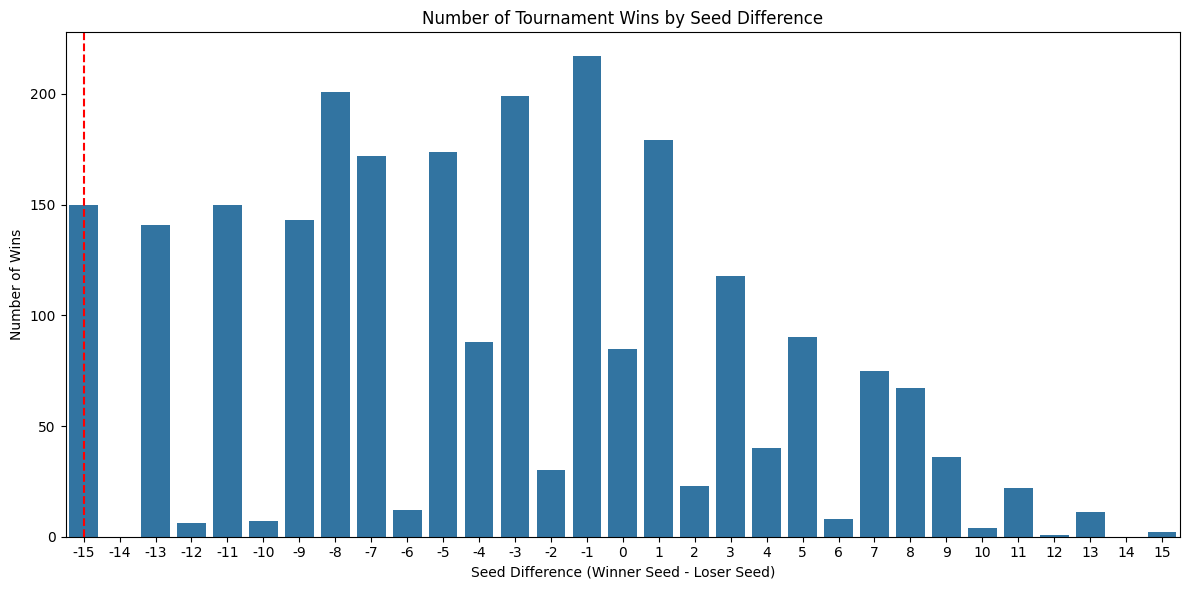

Upset Rate (Higher seed losing): 27.58%


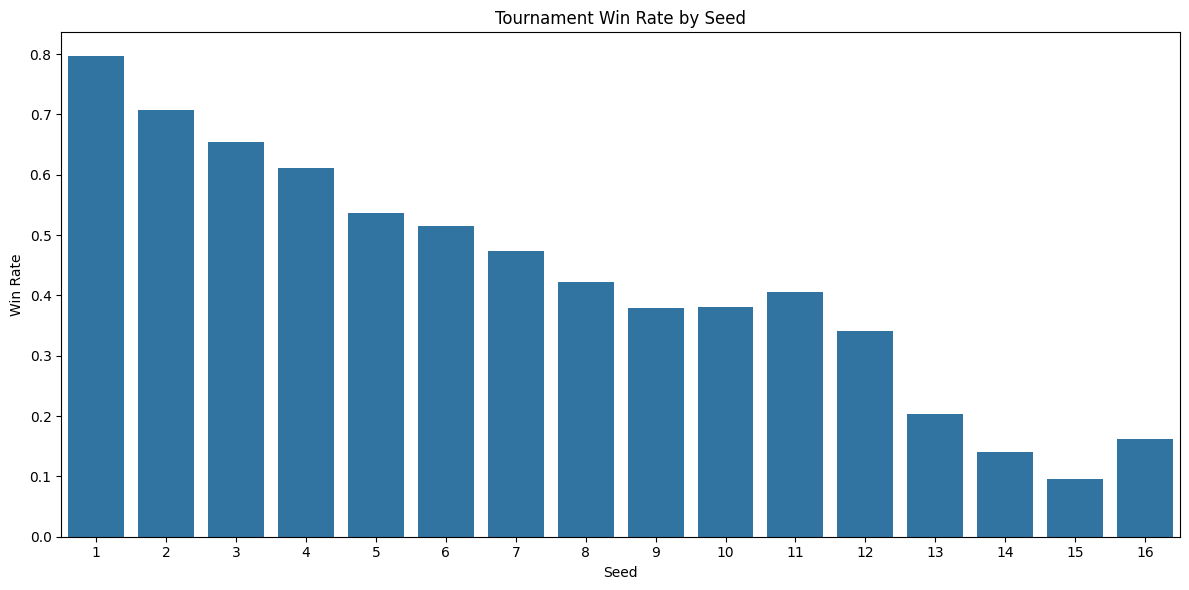

In [59]:
# Analyze the importance of seed-based features
def analyze_seed_features(tourney_games_with_seeds):
    """
    Analyze the importance of seed-based features for predicting tournament outcomes.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Calculate win probabilities by seed difference
    seed_diff_wins = tourney_games_with_seeds.groupby('SeedDiff').agg(
        Wins=('WTeamID', 'count')
    ).reset_index()
    
    # Count games by seed difference
    all_seed_diffs = pd.DataFrame({
        'SeedDiff': list(range(-15, 16))
    })
    
    # Merge to get games with zero seed differences too
    seed_diff_wins = all_seed_diffs.merge(seed_diff_wins, on='SeedDiff', how='left').fillna(0)
    
    # Plot wins by seed difference
    plt.figure(figsize=(12, 6))
    sns.barplot(x='SeedDiff', y='Wins', data=seed_diff_wins)
    plt.title('Number of Tournament Wins by Seed Difference')
    plt.xlabel('Seed Difference (Winner Seed - Loser Seed)')
    plt.ylabel('Number of Wins')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Calculate upset rate by seed difference
    upsets = tourney_games_with_seeds[tourney_games_with_seeds['SeedDiff'] > 0]
    total_games = len(tourney_games_with_seeds)
    upset_rate = len(upsets) / total_games
    
    print(f"Upset Rate (Higher seed losing): {upset_rate:.2%}")
    
    # Calculate win probabilities by seed
    seed_wins = tourney_games_with_seeds.groupby('WSeedNumber').size().reset_index(name='Wins')
    seed_losses = tourney_games_with_seeds.groupby('LSeedNumber').size().reset_index(name='Losses')
    
    seed_performance = pd.merge(seed_wins, seed_losses, left_on='WSeedNumber', right_on='LSeedNumber', how='outer').fillna(0)
    seed_performance = seed_performance.rename(columns={'WSeedNumber': 'Seed'})
    seed_performance = seed_performance.drop('LSeedNumber', axis=1)
    
    seed_performance['Games'] = seed_performance['Wins'] + seed_performance['Losses']
    seed_performance['Win_Rate'] = seed_performance['Wins'] / seed_performance['Games']
    
    # Plot win rate by seed
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Seed', y='Win_Rate', data=seed_performance)
    plt.title('Tournament Win Rate by Seed')
    plt.xlabel('Seed')
    plt.ylabel('Win Rate')
    plt.tight_layout()
    plt.show()

# Analyze seed features
analyze_seed_features(tourney_games_with_seeds)

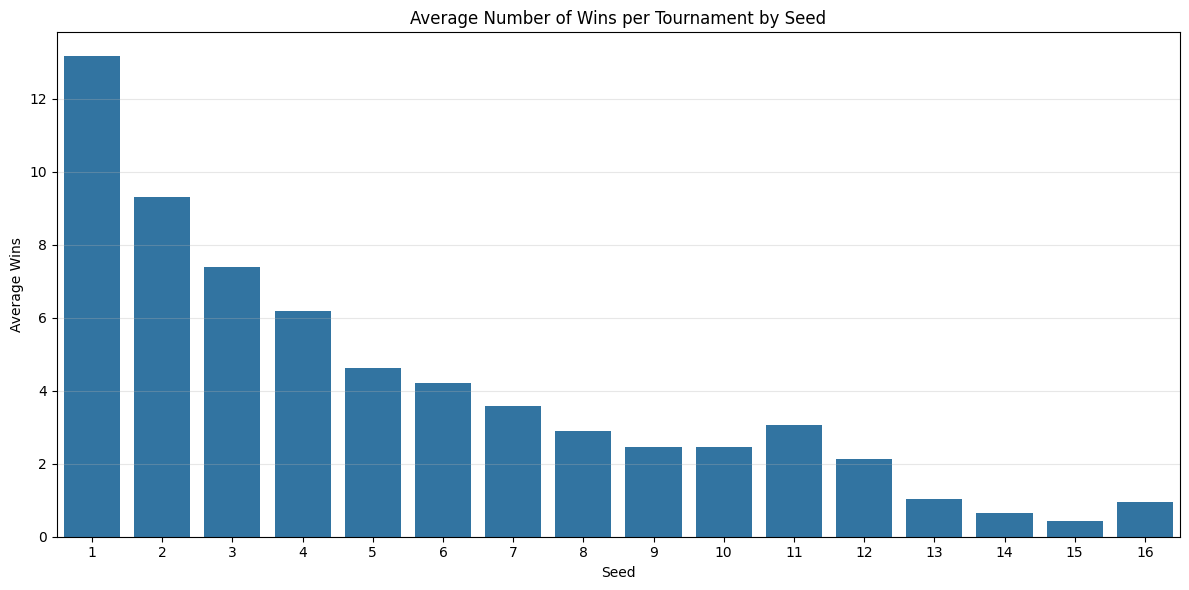

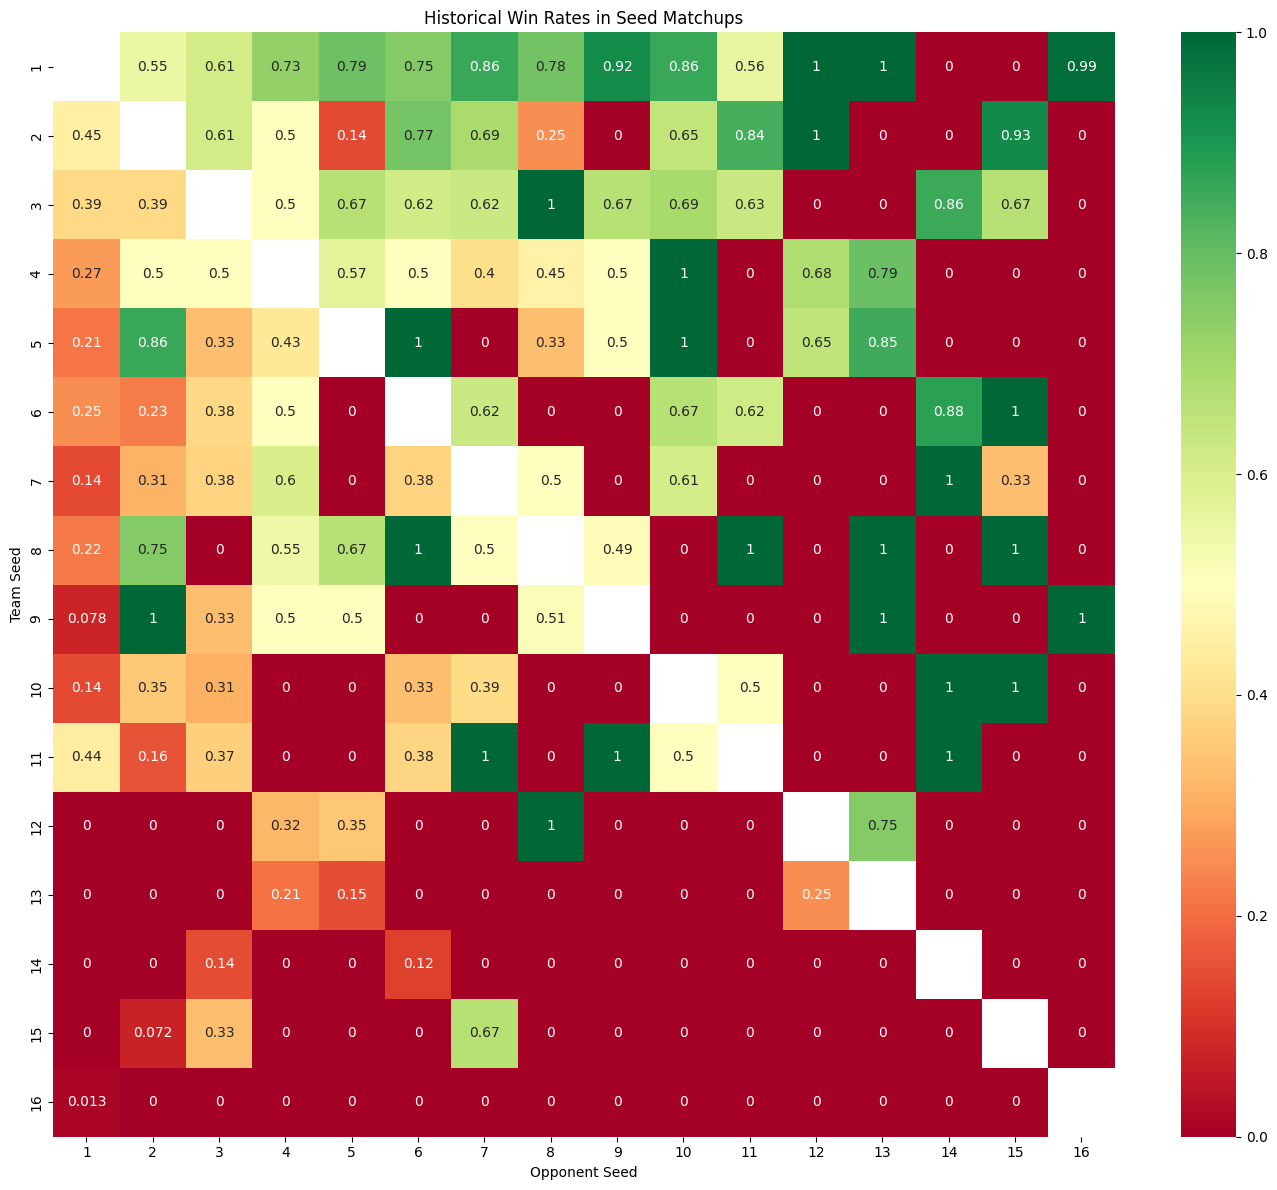

In [60]:
# Final Visualization - Seed Performance in the Tournament
def visualize_seed_performance():
    """
    Create visualizations of seed performance in the tournament.
    """
    # Calculate average wins by seed
    seed_stats = seed_historical[seed_historical['Season'] == seed_historical['Season'].max()]
    
    # Plot average wins per tournament by seed
    plt.figure(figsize=(12, 6))
    sns.barplot(x='SeedNumber', y='Seed_Avg_Wins_Per_Tourney', data=seed_stats)
    plt.title('Average Number of Wins per Tournament by Seed')
    plt.xlabel('Seed')
    plt.ylabel('Average Wins')
    plt.xticks(range(16), range(1, 17))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot win rate matrix by seed matchup
    win_rate_matrix = np.zeros((16, 16))
    for i in range(16):
        row_seed = seed_stats[seed_stats['SeedNumber'] == i+1]
        if not row_seed.empty:
            for j in range(16):
                col_name = f'Win_Rate_vs_Seed_{j+1}'
                if col_name in row_seed.columns:
                    win_rate_matrix[i, j] = row_seed[col_name].values[0]
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(win_rate_matrix, annot=True, cmap='RdYlGn', vmin=0, vmax=1,
                xticklabels=range(1, 17), yticklabels=range(1, 17))
    plt.title('Historical Win Rates in Seed Matchups')
    plt.xlabel('Opponent Seed')
    plt.ylabel('Team Seed')
    plt.tight_layout()
    plt.show()

# Visualize seed performance
visualize_seed_performance()

In [61]:
print("\n=== Data Preparation Complete ===")
print("The following datasets are now ready for modeling:")
print("1. Team Features - Contains all engineered features for each team")
print("2. Tournament Matchups - Contains all possible matchups with feature differences")
print("These datasets can be used to train a model to predict the outcome of tournament games.")


=== Data Preparation Complete ===
The following datasets are now ready for modeling:
1. Team Features - Contains all engineered features for each team
2. Tournament Matchups - Contains all possible matchups with feature differences
These datasets can be used to train a model to predict the outcome of tournament games.
